In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from astropy.coordinates import SkyCoord
import astropy.units as u

In [5]:
# Load the data - stream file from STREAMFINDER spec follow-up (Ibata et al. 2021)
stream_df = pd.read_csv('ibata_2021_streams.csv')

In [6]:
stream_df.columns

Index(['Gaia', 'RAJ2000', 'DEJ2000', 'plx', 'pmRA', 'pmDE', 'Gmag0', 'BP_RP_0',
       'dSF', 'HRV', 'e_HRV', 'r_HRV', 'Stream', 'Sloan'],
      dtype='object')

<Axes: xlabel='RAJ2000', ylabel='DEJ2000'>

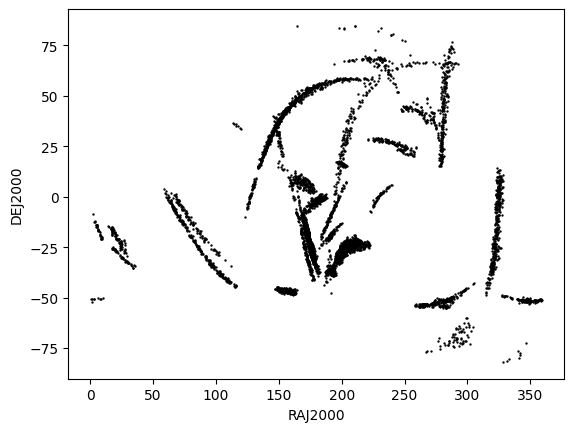

In [7]:
# Plot RA and Dec
stream_df.plot.scatter("RAJ2000", "DEJ2000", marker=".", color="k", s=2)

In [8]:
# Input params to compute orbits
params = ["RAJ2000","DEJ2000", "dSF", "pmRA", "pmDE", "HRV"]

In [9]:
stream_df.loc[:, params].head()

,RAJ2000,DEJ2000,dSF,pmRA,pmDE,HRV
0,0.555095,-50.846349,9.3,8.388,-4.010,NaN
1,1.515135,-51.976175,11.9,6.889,-3.500,NaN
2,1.773111,-50.834348,10.0,7.972,-3.240,NaN
3,1.875748,-8.429740,7.0,0.264,0.520,NaN
4,2.854624,-50.733300,10.3,7.136,-3.877,NaN


In [10]:
stream_df_nona = stream_df.loc[:, params].dropna()
stream_df_nona.head()

,RAJ2000,DEJ2000,dSF,pmRA,pmDE,HRV
5,3.111449,-50.615773,11.0,7.975,-3.357,27.90
11,4.915399,-14.040873,7.1,0.178,-0.045,6.06
19,6.204074,-16.111018,6.8,0.470,0.589,-18.41
24,6.760089,-16.775194,7.0,0.257,-0.125,-3837.77
57,17.804274,-24.746735,18.4,-0.240,-0.992,-118.97


In [18]:
single_star = stream_df_nona.iloc[6]
single_star

RAJ2000     18.091005
DEJ2000    -25.747818
dSF         25.100000
pmRA        -0.302000
pmDE        -0.928000
HRV       -117.670000
Name: 61, dtype: float64

## Initializing the orbit

In [19]:
#Orbit([RA,Dec,distance,pmRA,pmDec,Vlos],radec=True) where RA and Dec are expressed in degrees, 
#the distance is expressed in kpc, proper motions are expressed in mas/yr (pmra = pmra’ * cos[Dec] ), 
#and Vlos is the heliocentric line-of-sight velocity given in km/s

# Compute orbits
stream_df_orbits = Orbit(single_star.values, radec=True, ro=8., vo=220.)
stream_df_orbits

## Integrating the orbit

In [20]:
%%time

# Set time for integration, can use physical units
ts = np.linspace(0,10.,10000)*u.Gyr

# Integrate the orbit and specify the potential
stream_df_orbits.integrate(ts,MWPotential2014)

CPU times: user 173 ms, sys: 2 µs, total: 173 ms
Wall time: 173 ms


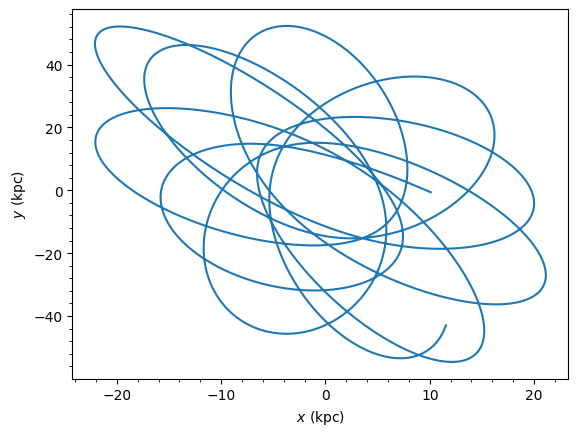

In [21]:
#stream_df_orbits.plot()
stream_df_orbits.plot(d1="x", d2="y")

## Computing orbital parameters

In [22]:
# apocentre, pericentre, eccentricity, zmax
stream_df_orbits.rap(), stream_df_orbits.rperi(), stream_df_orbits.e(), stream_df_orbits.zmax()

(56.41115587062037, 15.002640842988702, 0.5798391478007021, 52.96844589771666)

In [23]:
# J_r, J_phi, J_z, E
stream_df_orbits.jr(), stream_df_orbits.jp(), stream_df_orbits.jz(), stream_df_orbits.E()

(1510.5363840636658,
 1600.7588166470778,
 3119.6935383392342,
 12921.702748620131)

In [24]:
#Creat coord object for all stream stars
stream_df_coords= SkyCoord(
             ra=stream_df.RAJ2000.values*u.deg,
             dec=stream_df.DEJ2000.values*u.deg,
             distance=stream_df.dSF.values*u.kpc,
             pm_ra_cosdec=stream_df.pmRA.values*u.mas/u.yr,
             pm_dec=stream_df.pmDE.values*u.mas/u.yr,
             radial_velocity=stream_df.HRV.values*u.km/u.s,
             frame='icrs')

stream_df_coords[:10]

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    [(0.5550946, -50.8463493,  9.3), (1.5151347, -51.9761751, 11.9),
     (1.7731105, -50.8343482, 10. ), (1.875748 ,  -8.4297405,  7. ),
     (2.8546245, -50.7333002, 10.3), (3.1114491, -50.6157726, 11. ),
     (3.2166034, -12.3131045,  7.2), (3.824391 , -12.0557274,  6.8),
     (3.9632298, -12.6432028,  6.9), (4.7171801, -13.8830239,  6.8)]
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    [( 8.388, -4.01 ,  nan), ( 6.889, -3.5  ,  nan),
     ( 7.972, -3.24 ,  nan), ( 0.264,  0.52 ,  nan),
     ( 7.136, -3.877,  nan), ( 7.975, -3.357, 27.9),
     ( 0.174, -0.165,  nan), (-0.136,  0.055,  nan),
     (-0.078,  0.012,  nan), (-0.763, -0.479,  nan)]>

In [25]:
#Orbit([RA,Dec,distance,pmRA,pmDec,Vlos],radec=True) where RA and Dec are expressed in degrees, 
#the distance is expressed in kpc, proper motions are expressed in mas/yr (pmra = pmra’ * cos[Dec] ), 
#and Vlos is the heliocentric line-of-sight velocity given in km/s

# Compute orbits
stream_df_orbits = Orbit(stream_df_coords, radec=True, ro=8., vo=220.)
stream_df_orbits

In [26]:
#Add columns to stream_track stars
stream_df.loc[:,'jr'] = stream_df_orbits.jr(pot=MWPotential2014)
stream_df.loc[:,'jp'] = stream_df_orbits.jp(pot=MWPotential2014) #azimuthal action (= Lz in spherical potential)
stream_df.loc[:,'jz'] = stream_df_orbits.jz(pot=MWPotential2014)
stream_df.loc[:,'E'] = stream_df_orbits.E(pot=MWPotential2014)
stream_df.loc[:,'r_peri'] = stream_df_orbits.rperi(analytic=True, pot=MWPotential2014)
stream_df.loc[:,'r_apo'] = stream_df_orbits.rap(analytic=True, pot=MWPotential2014)
stream_df.loc[:,'ecc'] = stream_df_orbits.e(analytic=True, pot=MWPotential2014)

/home/kryo6156/work/talks/group_meeting_091224/.direnv/python-3.8.10/lib/python3.8/site-packages/galpy/util/coords.py:2025: RuntimeWarning: overflow encountered in sinh
  R = delta * numpy.sinh(u) * numpy.sin(v)

/home/kryo6156/work/talks/group_meeting_091224/.direnv/python-3.8.10/lib/python3.8/site-packages/galpy/util/coords.py:2026: RuntimeWarning: overflow encountered in cosh
  z = delta * numpy.cosh(u) * numpy.cos(v)

/home/kryo6156/work/talks/group_meeting_091224/.direnv/python-3.8.10/lib/python3.8/site-packages/galpy/actionAngle/actionAngleStaeckel.py:497: RuntimeWarning: invalid value encountered in add
  e = (rap - rperi) / (rap + rperi)



In [27]:
stream_df.columns

Index(['Gaia', 'RAJ2000', 'DEJ2000', 'plx', 'pmRA', 'pmDE', 'Gmag0', 'BP_RP_0',
       'dSF', 'HRV', 'e_HRV', 'r_HRV', 'Stream', 'Sloan', 'jr', 'jp', 'jz',
       'E', 'r_peri', 'r_apo', 'ecc'],
      dtype='object')

In [154]:
#stream_tracks.to_csv('../data_files/stream_tracks+gaia+dynam.csv', index=False)

## Energy vs Lz 

Text(0, 0.5, 'E $(\\mathrm{km}^{-2} \\cdot \\mathrm{s}^{-2})$')

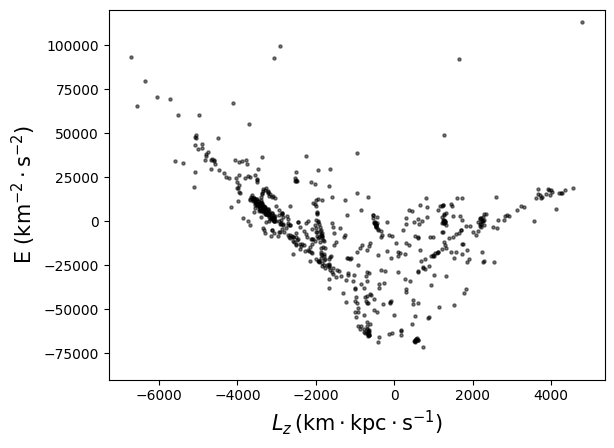

In [28]:
fig = plt.figure(111)
ax = fig.add_subplot(111)

ax.scatter(stream_df.jp, stream_df.E, s=5, c='k', alpha=0.5)

#ax.set_xlim(-2000, 3000)                                                        
ax.set_ylim(-90000, 120000)                                                   
                                                                                
ax.set_xlabel(r'$L_z\, (\mathrm{km} \cdot \mathrm{kpc} \cdot \mathrm{s}^{-1})$',
                size=15)                                                        
ax.set_ylabel(r'E $(\mathrm{km}^{-2} \cdot \mathrm{s}^{-2})$',                  
                size=15) 